In [1]:
cd ..

/media/hjp/FAAC278CAC27430D/HJP/KUAICV/Hand/AbsoluteTrack


In [2]:
pwd

'/media/hjp/FAAC278CAC27430D/HJP/KUAICV/Hand/AbsoluteTrack'

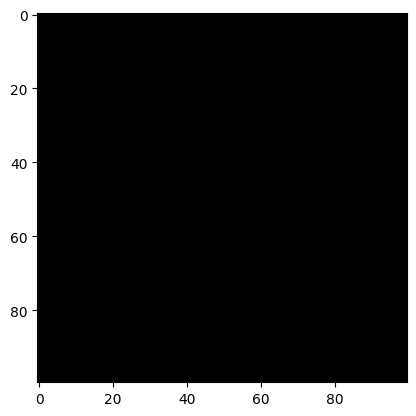

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# matplotlib
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive, IntSlider, Output
from IPython.display import clear_output, display

# %matplotlib widget 

import mediapipe as mp



img = np.zeros((100, 100), dtype=np.uint8)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [4]:
# LICENSE file in the root directory of this source tree.

import os

import av
import fnmatch
import pickle
import numpy as np
import torch

import lib.data_utils.fs as fs

from functools import partial

# from lib.tracker.perspective_crop import landmarks_from_hand_pose


#from multiprocessing import Pool
#from typing import Optional, Tuple

from lib.models.model_loader import load_pretrained_model

#from lib.tracker.tracker import HandTracker, HandTrackerOpts, InputFrame, ViewData
from lib.tracker.video_pose_data import SyncedImagePoseStream

from typing import Dict, NamedTuple

#from lib.common.hand import NUM_HANDS, NUM_LANDMARKS_PER_HAND
NUM_HANDS = 2
NUM_LANDMARKS_PER_HAND = 21
NUM_FINGERTIPS_PER_HAND = 5
NUM_JOINTS_PER_HAND = 22
LEFT_HAND_INDEX = 0
RIGHT_HAND_INDEX = 1

NUM_DIGITS: int = 5
NUM_JOINT_FRAMES: int = 1 + 1 + 3 * 5  # root + wrist + finger frames * 5
DOF_PER_FINGER: int = 4

# import from lib.common.affine.py

In [5]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import numpy as np
from scipy.spatial.transform import Rotation


def transform3(m, v):
    return transform_vec3(m, v) + m[..., :3, 3]


def transform_vec3(m, v):
    if m.ndim == 2:
        return (v.reshape(-1, 3) @ m[:3, :3].T).reshape(v.shape)
    else:
        return (m[..., :3, :3] @ v[..., None]).squeeze(-1)


def normalized(v: np.ndarray, axis: int = -1, eps: float = 5.43e-20) -> np.ndarray:
    d = np.maximum(eps, (v * v).sum(axis=axis, keepdims=True) ** 0.5)
    return v / d


def skew_matrix(v: np.ndarray) -> np.ndarray:
    res = np.array(
        [[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]], dtype=v.dtype
    )
    return res


def from_two_vectors(a_orig: np.ndarray, b_orig: np.ndarray) -> np.ndarray:
    a = normalized(a_orig)
    b = normalized(b_orig)
    v = np.cross(a, b)
    s = np.linalg.norm(v)
    c = np.dot(a, b)
    v_mat = skew_matrix(v)

    rot = np.eye(3, 3) + v_mat + np.matmul(v_mat, v_mat) * (1 - c) / (max(s * s, 1e-15))

    return rot


def make_look_at_matrix(
    orig_world_to_eye: np.ndarray,
    center: np.ndarray,
    camera_angle: float = 0,
) -> np.ndarray:
    """
    args:
        orig_world_to_eye:  world to eye transform
            inverse of camera.camera_to_world_xf
        center:  np.array. (3,)
            3D world coordinate of center of the object of interest
        camera_angle: the angle of the camera
            camera_angle: how the camera is oriented physically so that we can rotate the object of
            interest to the 'upright' direction
    """
    center_local = transform3(orig_world_to_eye, center)
    z_dir_local = center_local / np.linalg.norm(center_local)
    
    delta_r_local = from_two_vectors(
        np.array([0, 0, 1], dtype=center.dtype), z_dir_local
    )
    orig_eye_to_world = np.linalg.inv(orig_world_to_eye)

    new_eye_to_world = orig_eye_to_world.copy()
    new_eye_to_world[0:3, 0:3] = orig_eye_to_world[0:3, 0:3] @ delta_r_local

    # Locally rotate the z axis to align with the camera angle
    z_local_rot = Rotation.from_euler("z", camera_angle, degrees=True).as_matrix()
    new_eye_to_world[0:3, 0:3] = new_eye_to_world[0:3, 0:3] @ z_local_rot

    return np.linalg.inv(new_eye_to_world)


# import from lib.common.crop.py

In [6]:

from typing import Tuple

import lib.common.camera as camera
import numpy as np


def gen_intrinsics_from_bounding_pts(
    pts_eye: np.ndarray, image_w: int, image_h: int, min_focal: float = 5
) -> Tuple[np.ndarray, np.ndarray]:
    pts_ndc = pts_eye[..., 0:2] / pts_eye[..., 2:]
    img_size = np.array([image_w, image_h], dtype=pts_eye.dtype)
    # Given our convention, we need to shift one pixel before dividing by 2.
    cx_cy = (img_size - 1) / 2
    fx_fy = cx_cy / np.absolute(pts_ndc).max()

    # Some sanity checks
    if np.any(pts_eye[..., 2:] < 0.0001) or np.any(fx_fy < min_focal):
        raise ValueError("Unable to create crop camera", fx_fy)

    return fx_fy, cx_cy


def gen_crop_parameters_from_points(
    camera_orig: camera.CameraModel,
    pts_world,
    new_image_size: Tuple[int, int],
    mirror_img_x: bool,
    camera_angle: float = 0,
    focal_multiplier: float = 0.95,
) -> camera.PinholePlaneCameraModel:
    """
    Given the original camera transform and a list of 3D points in the world space,
    compute the new perspective camera that makes sure after projection all the points
    can be projected inside the image.

    Auguments:
    * camera_orig: the original camera used for generating an image. The returned camera
        will have the same position but different rotation and intrinsics parameters.
    * pts_world: points in the world space that must be projected inside the image by
        the generated world to eye transform and intrinsics.
    * new_image_size: target image size
    * mirror_img_x: whether to flip the image. A typical use case is we usually mirror the
        right hand images so that a model need to handle left hand data only
    * camera_angle: how the camera is oriented physically so that we can rotate the object of
        interest to the 'upright' direction
    * focal_multiplier: when less than 1, we are zooming out a little. The effect on the image
        is some margin will be left at the boundary.
    """
    orig_world_to_eye_xf = np.linalg.inv(camera_orig.camera_to_world_xf)

    crop_center = (pts_world.min(axis=0) + pts_world.max(axis=0)) / 2.0
    new_world_to_eye = make_look_at_matrix(
        orig_world_to_eye_xf, crop_center, camera_angle
    )
    if mirror_img_x:
        mirrorx = np.eye(4, dtype=np.float32)
        mirrorx[0, 0] = -1
        new_world_to_eye = mirrorx @ new_world_to_eye

    fx_fy, cx_cy = gen_intrinsics_from_bounding_pts(
        transform3(new_world_to_eye, pts_world),
        new_image_size[0],
        new_image_size[1],
    )
    fx_fy = focal_multiplier * fx_fy

    return camera.PinholePlaneCameraModel(
        width=new_image_size[0],
        height=new_image_size[1],
        f=fx_fy,
        c=cx_cy,
        distort_coeffs=[],
        camera_to_world_xf=np.linalg.inv(new_world_to_eye),
    )


# import from lib.tracker.tracking_result 

In [7]:
from typing import Dict, NamedTuple

class SingleHandPose(NamedTuple):
    """
    A hand pose is composed of two fields:
    1) joint angles where # joints == # DoFs
    2) root-to-world rigid wrist transformation
    """

    joint_angles: np.ndarray = np.zeros(NUM_JOINTS_PER_HAND, dtype=np.float32)
    wrist_xform: np.ndarray = np.eye(4, dtype=np.float32)
    hand_confidence: float = 1.0


# Tracking result maps from hand_index to hand_pose
class TrackingResult(NamedTuple):
    hand_poses: Dict[int, SingleHandPose] = {}
    num_views: Dict[int, int] = {}
    predicted_scales: Dict[int, float] = {}


# import from lib.common.crop

In [8]:

from typing import Tuple

import lib.common.camera as camera

import numpy as np

# from . import affine

def gen_intrinsics_from_bounding_pts(
    pts_eye: np.ndarray, image_w: int, image_h: int, min_focal: float = 5
) -> Tuple[np.ndarray, np.ndarray]:
    pts_ndc = pts_eye[..., 0:2] / pts_eye[..., 2:]
    img_size = np.array([image_w, image_h], dtype=pts_eye.dtype)
    # Given our convention, we need to shift one pixel before dividing by 2.
    cx_cy = (img_size - 1) / 2
    fx_fy = cx_cy / np.absolute(pts_ndc).max()

    # Some sanity checks
    if np.any(pts_eye[..., 2:] < 0.0001) or np.any(fx_fy < min_focal):
        raise ValueError("Unable to create crop camera", fx_fy)

    return fx_fy, cx_cy


def gen_crop_parameters_from_points(
    camera_orig: camera.CameraModel,
    pts_world,
    new_image_size: Tuple[int, int],
    mirror_img_x: bool,
    camera_angle: float = 0,
    focal_multiplier: float = 0.95,
) -> camera.PinholePlaneCameraModel:
    """
    Given the original camera transform and a list of 3D points in the world space,
    compute the new perspective camera that makes sure after projection all the points
    can be projected inside the image.

    Auguments:
    * camera_orig: the original camera used for generating an image. The returned camera
        will have the same position but differet rotation and intrinsics parameters.
    * pts_world: np.array. (21, 3) or (42, 3) or (63, 3)
        points in the world space that must be projected inside the image by
        the generated world to eye transform and intrinsics.
    * new_image_size: target image size
    * mirror_img_x: whether to flip the image. A typical use case is we usually mirror the
        right hand images so that a model need to handle left hand data only
    * camera_angle: how the camera is oriented physically so that we can rotate the object of
        interest to the 'upright' direction
    * focal_multiplier: when less than 1, we are zooming out a little. The effect on the image
        is some margin will be left at the boundary.
    """
    orig_world_to_eye_xf = np.linalg.inv(camera_orig.camera_to_world_xf)

    crop_center = (pts_world.min(axis=0) + pts_world.max(axis=0)) / 2.0
    new_world_to_eye = make_look_at_matrix(
        orig_world_to_eye_xf, crop_center, camera_angle
    )
    if mirror_img_x:
        mirrorx = np.eye(4, dtype=np.float32)
        mirrorx[0, 0] = -1
        new_world_to_eye = mirrorx @ new_world_to_eye

    fx_fy, cx_cy = gen_intrinsics_from_bounding_pts(
        transform3(new_world_to_eye, pts_world),
        new_image_size[0],
        new_image_size[1],
    )
    fx_fy = focal_multiplier * fx_fy

    return camera.PinholePlaneCameraModel(
        width=new_image_size[0],
        height=new_image_size[1],
        f=fx_fy,
        c=cx_cy,
        distort_coeffs=[],
        camera_to_world_xf=np.linalg.inv(new_world_to_eye),
    )


# import from lib.tracker.perspective_crop.py

In [9]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

from typing import Dict, List, Optional, Tuple

import lib.common.camera as camera
import numpy as np
import torch
#from lib.common.crop import gen_crop_parameters_from_points
from lib.common.hand import HandModel, NUM_JOINTS_PER_HAND, RIGHT_HAND_INDEX
from lib.common.hand_skinning import skin_landmarks

#from .tracking_result import SingleHandPose


def neutral_joint_angles(up: HandModel, lower_factor: float = 0.5) -> torch.Tensor:
    joint_limits = up.joint_limits
    assert joint_limits is not None
    return joint_limits[..., 0] * lower_factor + joint_limits[..., 1] * (
        1 - lower_factor
    )


def skin_landmarks_np(
    hand_model: HandModel,
    joint_angles: np.ndarray,
    wrist_transforms: np.ndarray,
) -> np.ndarray:
    landmarks = skin_landmarks(
        hand_model,
        torch.from_numpy(joint_angles).float(),
        torch.from_numpy(wrist_transforms).float(),
    )
    return landmarks.numpy()


def landmarks_from_hand_pose(
    hand_model: HandModel, hand_pose: SingleHandPose, hand_idx: int
) -> np.ndarray:
    """
    Compute 3D landmarks in the world space given the hand model and hand pose.
    """
    xf = hand_pose.wrist_xform.copy()
    # This function expects the user hand model to be a left hand.
    if hand_idx == RIGHT_HAND_INDEX:
        xf[:, 0] *= -1
    landmarks = skin_landmarks_np(hand_model, hand_pose.joint_angles, xf)
    return landmarks


def rank_hand_visibility_in_cameras(
    cameras: List[camera.CameraModel],
    hand_model: HandModel,
    hand_pose: SingleHandPose,
    hand_idx: int,
    min_required_vis_landmarks: int,
) -> List[int]:
    landmarks_world = landmarks_from_hand_pose(
        hand_model, hand_pose, hand_idx
    )
    
    # list of number of 3D keypoints that project into views for each camera
    n_landmarks_in_view = []
    
    # list of camera indices that can see enough hand points
    ranked_cam_indices = []
    for cam_idx, camera in enumerate(cameras):
        # (21, 3)
        landmarks_eye = camera.world_to_eye(landmarks_world)
        
        # (21, 2)
        landmarks_win2 = camera.eye_to_window(landmarks_eye)
        
        n_visible = (
            (landmarks_win2[..., 0] >= 0)
            & (landmarks_win2[..., 0] <= camera.width - 1)
            & (landmarks_win2[..., 1] >= 0)
            & (landmarks_win2[..., 1] <= camera.height - 1)
            & (landmarks_eye[..., 2] > 0)
        ).sum()

        n_landmarks_in_view.append(n_visible)
        # Only push the cameras that can see enough hand points
        if n_visible >= min_required_vis_landmarks:
            ranked_cam_indices.append(cam_idx)

    # print("ranked_cam_indices", ranked_cam_indices)
    # print("n_landmarks_in_view", n_landmarks_in_view)   

    #  Favor the view that sees more landmarks
    ranked_cam_indices.sort(
        reverse=True,
        key=lambda x: n_landmarks_in_view[x],
    )
    # print("ranked_cam_indices", ranked_cam_indices)
    return ranked_cam_indices


def _get_crop_points_from_hand_pose(
    hand_model: HandModel,
    gt_hand_pose: SingleHandPose,
    hand_idx: int,
    num_crop_points: int,
) -> np.ndarray:
    '''
    args :
        hand_model : HandModel
        
        gt_hand_pose : SingleHandPose
        
        hand_idx : int

        num_crop_points : int
            ㅅㅂ WTF does num_crop_points do?
    
    return :
        np.ndarray of shape (num_crop_points, 3)
        each row is a 3D keypoint in the 3D coordinate
        (not sure world space or eye space)
    '''
    assert num_crop_points in [21, 42, 63]
    neutral_hand_pose = SingleHandPose(
        joint_angles=neutral_joint_angles(hand_model).numpy(),
        wrist_xform=gt_hand_pose.wrist_xform,
    )
    open_hand_pose = SingleHandPose(
        joint_angles=np.zeros(NUM_JOINTS_PER_HAND, dtype=np.float32),
        wrist_xform=gt_hand_pose.wrist_xform,
    )

    crop_points = []
    crop_points.append(landmarks_from_hand_pose(
        hand_model, gt_hand_pose, hand_idx)
    )
    if num_crop_points > 21:
        crop_points.append(
            landmarks_from_hand_pose(
                hand_model, neutral_hand_pose, hand_idx
            )
        )
    if num_crop_points > 42:
        crop_points.append(
            landmarks_from_hand_pose(
                hand_model, open_hand_pose, hand_idx
            )
        )
    
    result = np.concatenate(crop_points, axis=0)
    # print("crop_points", result.shape)
    
    return result

def gen_crop_cameras_from_pose(
    cameras: List[camera.CameraModel],
    camera_angles: List[float],
    hand_model: HandModel,
    hand_pose: SingleHandPose,
    hand_idx: int,
    num_crop_points: int,
    new_image_size: Tuple[int, int],
    max_view_num: Optional[int] = None,
    sort_camera_index: bool = False,
    focal_multiplier: float = 0.95,
    mirror_right_hand: bool = True,
    min_required_vis_landmarks: int = 19,
) -> Dict[int, camera.PinholePlaneCameraModel]:
    
    crop_cameras: Dict[int, camera.PinholePlaneCameraModel] = {}

    # keypoints coordinates in the world space
    crop_points = _get_crop_points_from_hand_pose(
        hand_model,
        hand_pose,
        hand_idx,
        num_crop_points,
    )
    
    # list of camera indices that can see enough hand points
    # sorted by the number of landmarks that can be seen, descending
    cam_indices = rank_hand_visibility_in_cameras(
        cameras=cameras,
        hand_model=hand_model,
        hand_pose=hand_pose,
        hand_idx=hand_idx,
        min_required_vis_landmarks=min_required_vis_landmarks,
    )

    # cam_indices is sorted by the number of landmarks that can be seen, descending
    # if sort_camera_index is True, then sort cam_indices
    if sort_camera_index:
        cam_indices = sorted(cam_indices)


    for cam_idx in cam_indices:
        crop_cameras[cam_idx] = gen_crop_parameters_from_points(
            cameras[cam_idx],
            crop_points,
            new_image_size,
            mirror_img_x=(mirror_right_hand and hand_idx == 1),
            camera_angle=camera_angles[cam_idx],
            focal_multiplier=focal_multiplier,
        )
        if len(crop_cameras) == max_view_num:
            break

    return crop_cameras


# import from tracker.py

In [10]:
# tracker.py

from dataclasses import dataclass
from typing import Dict, List, Optional

import cv2

import lib.common.camera as camera
import numpy as np
import torch


from lib.common.hand import HandModel, NUM_HANDS, scaled_hand_model

from lib.data_utils import bundles

from lib.models.regressor import RegressorOutput
from lib.models.umetrack_model import InputFrameData, InputFrameDesc, InputSkeletonData


MM_TO_M = 0.001
M_TO_MM = 1000.0
MIN_OBSERVED_LANDMARKS = 21
CONFIDENCE_THRESHOLD = 0.5
MAX_VIEW_NUM = 2


@dataclass
class ViewData:
    image: np.ndarray
    camera: camera.CameraModel
    camera_angle: float


@dataclass
class InputFrame:
    views: List[ViewData]

@dataclass
class HandTrackerOpts:
    
    num_crop_points: int = 63
    # can be [21, 42, 63]
    # when performing perspective crop,
    # 21: crop along detected pose ?
    # 42: crop along detected pose + open pose
    # 63: crop along detected pose + open pose + neutral pose
    
    enable_memory: bool = True
    
    use_stored_pose_for_crop: bool = True
    
    hand_ratio_in_crop: float = 0.95
    
    min_required_vis_landmarks: int = 19

def _warp_image(
    src_camera: camera.CameraModel,
    dst_camera: camera.CameraModel,
    src_image: np.ndarray,
    interpolation: int = cv2.INTER_LINEAR,
    depth_check: bool = True,
) -> np.ndarray:
    W, H = dst_camera.width, dst_camera.height
    px, py = np.meshgrid(np.arange(W), np.arange(H))
    dst_win_pts = np.column_stack((px.flatten(), py.flatten()))

    dst_eye_pts = dst_camera.window_to_eye(dst_win_pts)
    world_pts = dst_camera.eye_to_world(dst_eye_pts)
    src_eye_pts = src_camera.world_to_eye(world_pts)
    src_win_pts = src_camera.eye_to_window(src_eye_pts)

    # Mask out points with negative z coordinates
    if depth_check:
        mask = src_eye_pts[:, 2] < 0
        src_win_pts[mask] = -1

    src_win_pts = src_win_pts.astype(np.float32)

    map_x = src_win_pts[:, 0].reshape((H, W))
    map_y = src_win_pts[:, 1].reshape((H, W))

    return cv2.remap(src_image, map_x, map_y, interpolation)

class HandTracker:
    def __init__(self, model, opts: HandTrackerOpts) -> None:
        self._device: str = "cuda" if torch.cuda.device_count() else "cpu"
        
        self._model = model
        self._model.to(self._device)

        self._input_size = np.array(self._model.getInputImageSizes())
        self._num_crop_points = opts.num_crop_points
        self._enable_memory = opts.enable_memory
        self._hand_ratio_in_crop: float = opts.hand_ratio_in_crop
        self._min_required_vis_landmarks: int = opts.min_required_vis_landmarks
        self._valid_tracking_history = np.zeros(2, dtype=bool)

    def reset_history(self) -> None:
        self._valid_tracking_history[:] = False
        
    def gen_crop_cameras_from_stereo_camera_with_window_hand_pose(
        self,
        camera_left: camera.CameraModel,
        camera_right: camera.CameraModel,
        window_hand_pose_left: Dict[int, np.ndarray],
        window_hand_pose_right: Dict[int, np.ndarray],
    ) :
        """
        window coordinate : pixel coordinate
        get crop_cameras from camera, view and 2D pose
        
        Assume that the camera is stereo camera
        args :
            camera_left : camera.CameraModel
            camera_right : camera.CameraModel
            window_hand_pose_left : Dict[int, np.ndarray]
            window_hand_pose_right : Dict[int, np.ndarray]
        """
        pass

    def gen_crop_cameras_analysis(
        self,
        #cameras: List[camera.CameraModel],
        input_frame,
        camera_angles: List[float],
        hand_model: HandModel,
        gt_tracking: Dict[int, SingleHandPose],
        min_num_crops: int,
    ) -> Dict[int, Dict[int, camera.PinholePlaneCameraModel]]:
    
        cameras = [view.camera for view in input_frame.views]
        
        crop_cameras: Dict[int, Dict[int, camera.PinholePlaneCameraModel]] = {}
        if not gt_tracking:
            return crop_cameras

        # evaluate for each detected hands.
        for hand_idx, gt_hand_pose in gt_tracking.items():
            if gt_hand_pose.hand_confidence < CONFIDENCE_THRESHOLD:
                continue

            # contains croped cameras in multi origin views for single hand
            crop_camera_dict_per_hand: Dict[int, camera.PinholePlaneCameraModel] = {}
            
            # contains camera indexes that target hand is visible in       
            valid_cam_index_list = sorted(rank_hand_visibility_in_cameras(
                cameras,
                hand_model,
                gt_hand_pose,
                hand_idx,
                self._min_required_vis_landmarks,
            ))

            world_hand_pose = _get_crop_points_from_hand_pose(
                hand_model,
                gt_hand_pose,
                hand_idx,
                #self._num_crop_points,
                21
            )

            for valid_cam_idx in valid_cam_index_list:
                orig_cam = cameras[valid_cam_idx]
                orig_cam_angle = camera_angles[valid_cam_idx]
                
                orig_world_to_eye_xf = np.linalg.inv(orig_cam.camera_to_world_xf)
                
                world_hand_pose_center = (
                    world_hand_pose.min(axis=0) + world_hand_pose.max(axis=0)
                ) / 2
                
                window_hand_pose = orig_cam.eye_to_window(
                    orig_cam.world_to_eye(world_hand_pose)
                ).astype(int)
                
                plt.imshow(input_frame.views[valid_cam_idx].image)
                plt.scatter(window_hand_pose[:, 0], window_hand_pose[:, 1])
                plt.show()
                
                
                print("world_hand_pose_center", world_hand_pose_center)
                print("cam_pos", orig_cam.camera_to_world_xf[:3, 3])
                
                new_world_to_eye = make_look_at_matrix(
                    orig_world_to_eye_xf,
                    world_hand_pose_center,
                    orig_cam_angle
                )
                
                if hand_idx == 1:
                    mirrorx = np.eye(4, dtype=np.float32)
                    mirrorx[0, 0] = -1
                    new_world_to_eye = mirrorx @ new_world_to_eye
                
                fx_fy, cx_cy = gen_intrinsics_from_bounding_pts(
                    transform3(new_world_to_eye, world_hand_pose),
                    self._input_size[0], self._input_size[1],
                )
                fx_fy = self._hand_ratio_in_crop * fx_fy
                
                new_cam = camera.PinholePlaneCameraModel(
                    width=self._input_size[0],
                    height=self._input_size[1],
                    f=fx_fy,
                    c=cx_cy,
                    distort_coeffs = [],
                    camera_to_world_xf=np.linalg.inv(new_world_to_eye),
                )
                crop_camera_dict_per_hand[valid_cam_idx] = new_cam

            crop_cameras[hand_idx] = crop_camera_dict_per_hand

        # Remove empty crop_cameras
        del_list = []
        for hand_idx, per_hand_crop_cameras in crop_cameras.items():
            if not per_hand_crop_cameras or len(per_hand_crop_cameras) < min_num_crops:
                del_list.append(hand_idx)
        for hand_idx in del_list:
            del crop_cameras[hand_idx]

        return crop_cameras


    def gen_crop_cameras(
        self,
        cameras: List[camera.CameraModel],
        camera_angles: List[float],
        hand_model: HandModel,
        gt_tracking: Dict[int, SingleHandPose],
        min_num_crops: int,
    ) -> Dict[int, Dict[int, camera.PinholePlaneCameraModel]]:
    
        '''
        args :
        return :
            crop_cameras: Dict[int, Dict[int, camera.PinholePlaneCameraModel]]
                key : hand_idx
                value : Dict[int, camera.PinholePlaneCameraModel]
                    key : cam_idx
                    value : camera.PinholePlaneCameraModel
        '''
        crop_cameras: Dict[int, Dict[int, camera.PinholePlaneCameraModel]] = {}
        if not gt_tracking:
            return crop_cameras

        for hand_idx, gt_hand_pose in gt_tracking.items():
            if gt_hand_pose.hand_confidence < CONFIDENCE_THRESHOLD:
                continue
            crop_cameras[hand_idx] = gen_crop_cameras_from_pose(
                cameras,
                camera_angles,
                hand_model,
                gt_hand_pose,
                hand_idx,
                self._num_crop_points,
                self._input_size,
                max_view_num=MAX_VIEW_NUM,
                sort_camera_index=True,
                focal_multiplier=self._hand_ratio_in_crop,
                mirror_right_hand=True,
                min_required_vis_landmarks=self._min_required_vis_landmarks,
            )

        # Remove empty crop_cameras
        del_list = []
        for hand_idx, per_hand_crop_cameras in crop_cameras.items():
            if not per_hand_crop_cameras or len(per_hand_crop_cameras) < min_num_crops:
                del_list.append(hand_idx)
        for hand_idx in del_list:
            del crop_cameras[hand_idx]

        return crop_cameras

    def track_frame(
        self,
        sample: InputFrame,
        hand_model: HandModel,
        crop_cameras: Dict[int, Dict[int, camera.PinholePlaneCameraModel]],
    ) -> TrackingResult:
        if not crop_cameras:
            # Frame without hands
            self.reset_history()
            return TrackingResult()

        frame_data, frame_desc, skeleton_data = self._make_inputs(
            sample, hand_model, crop_cameras
        )
        with torch.no_grad():
            regressor_output = bundles.to_device(
                self._model.regress_pose_use_skeleton(
                    frame_data, frame_desc, skeleton_data
                ),
                torch.device("cpu"),
            )

        tracking_result = self._gen_tracking_result(
            regressor_output,
            frame_desc.hand_idx.cpu().numpy(),
            crop_cameras,
        )
        return tracking_result

    def track_frame_and_calibrate_scale(
        self,
        sample: InputFrame,
        crop_cameras: Dict[int, Dict[int, camera.PinholePlaneCameraModel]],
    ) -> TrackingResult:
        if not crop_cameras:
            # Frame without hands
            self.reset_history()
            return TrackingResult()
        frame_data, frame_desc, _ = self._make_inputs(sample, None, crop_cameras)

        with torch.no_grad():
            regressor_output = bundles.to_device(
                self._model.regress_pose_pred_skel_scale(frame_data, frame_desc),
                torch.device("cpu"),
            )

        tracking_result = self._gen_tracking_result(
            regressor_output,
            frame_desc.hand_idx.cpu().numpy(),
            crop_cameras,
        )
        return tracking_result

    def _make_inputs(
        self,
        sample: InputFrame,
        hand_model_mm: Optional[HandModel],
        crop_cameras: Dict[int, Dict[int, camera.PinholePlaneCameraModel]],
    ):
        image_idx = 0
        left_images = []
        intrinsics = []
        extrinsics_xf = []
        sample_range_n_hands = []
        hand_indices = []
        for hand_idx, crop_camera_info in crop_cameras.items():
            sample_range_start = image_idx
            for cam_idx, crop_camera in crop_camera_info.items():
                view_data = sample.views[cam_idx]
                crop_image = _warp_image(view_data.camera, crop_camera, view_data.image)
                left_images.append(crop_image.astype(np.float32) / 255.0)
                intrinsics.append(crop_camera.uv_to_window_matrix())

                crop_world_to_eye_xf = np.linalg.inv(crop_camera.camera_to_world_xf)
                crop_world_to_eye_xf[:3, 3] *= MM_TO_M
                extrinsics_xf.append(crop_world_to_eye_xf)

                image_idx += 1

            if image_idx > sample_range_start:
                hand_indices.append(hand_idx)
                sample_range_n_hands.append(np.array([sample_range_start, image_idx]))

        hand_indices = np.array(hand_indices)
        frame_data = InputFrameData(
            left_images=torch.from_numpy(np.stack(left_images)).float(),
            intrinsics=torch.from_numpy(np.stack(intrinsics)).float(),
            extrinsics_xf=torch.from_numpy(np.stack(extrinsics_xf)).float(),
        )
        frame_desc = InputFrameDesc(
            sample_range=torch.from_numpy(np.stack(sample_range_n_hands)).long(),
            memory_idx=torch.from_numpy(hand_indices).long(),
            # use memory if the hand is previously valid
            use_memory=torch.from_numpy(
                self._valid_tracking_history[hand_indices]
            ).bool(),
            hand_idx=torch.from_numpy(hand_indices).long(),
        )
        skeleton_data = None
        if hand_model_mm is not None:
            # m -> mm
            hand_model_m = scaled_hand_model(hand_model_mm, MM_TO_M)
            skeleton_data = InputSkeletonData(
                joint_rotation_axes=hand_model_m.joint_rotation_axes.float(),
                joint_rest_positions=hand_model_m.joint_rest_positions.float(),
            )
        return bundles.to_device((frame_data, frame_desc, skeleton_data), self._device)

    def _gen_tracking_result(
        self,
        regressor_output: RegressorOutput,
        hand_indices: np.ndarray,
        crop_cameras: Dict[int, Dict[int, camera.PinholePlaneCameraModel]],
    ) -> TrackingResult:

        output_joint_angles = regressor_output.joint_angles.to("cpu").numpy()
        output_wrist_xforms = regressor_output.wrist_xfs.to("cpu").numpy()
        output_wrist_xforms[..., :3, 3] *= M_TO_MM
        output_scales = None
        if regressor_output.skel_scales is not None:
            output_scales = regressor_output.skel_scales.to("cpu").numpy()

        hand_poses = {}
        num_views = {}
        predicted_scales = {}

        for output_idx, hand_idx in enumerate(hand_indices):
            raw_handpose = SingleHandPose(
                joint_angles=output_joint_angles[output_idx],
                wrist_xform=output_wrist_xforms[output_idx],
                hand_confidence=1.0,
            )
            hand_poses[hand_idx] = raw_handpose
            num_views[hand_idx] = len(crop_cameras[hand_idx])
            if output_scales is not None:
                predicted_scales[hand_idx] = output_scales[output_idx]

        for hand_idx in range(NUM_HANDS):
            hand_valid = False
            if hand_idx in hand_poses:
                self._valid_tracking_history[hand_idx] = True
                hand_valid = True
            if hand_valid:
                continue
            self._valid_tracking_history[hand_idx] = False

        return TrackingResult(
            hand_poses=hand_poses,
            num_views=num_views,
            predicted_scales=predicted_scales,
        )


In [11]:
import logging
import os

logging.basicConfig(level = logging.INFO)
logger = logging.getLogger(__name__)

# model_name = "pretrained_weights.torch"
# model_path = os.path.join(".", "pretrained_models", model_name)
# model = load_pretrained_model(model_path)
# model.eval()
# tracker = HandTracker(model, HandTrackerOpts())

DATA_PATH = "sample_data/recording_00.mp4"
image_pose_stream = SyncedImagePoseStream(DATA_PATH)
hand_model = image_pose_stream._hand_pose_labels.hand_model

image_pose_list = []
for (input_frame, gt_tracking) in image_pose_stream:
    image_pose_list.append((input_frame, gt_tracking))

Opened (30 fps) video from sample_data/recording_00.mp4


# Parse and analyze GT annotatio

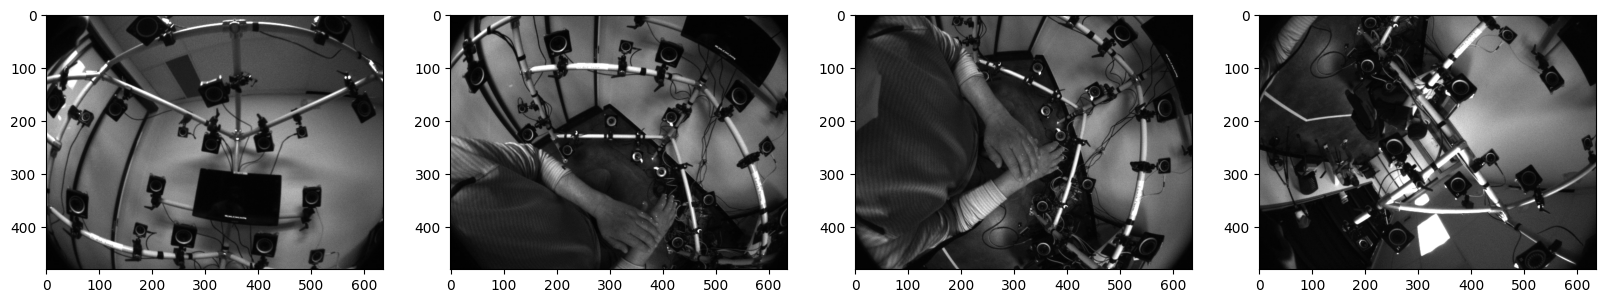

2 [[-9.03648511e-02  5.86615466e-02 -9.94179547e-01 -8.75907669e+01]
 [ 5.40197551e-01  8.41538072e-01  5.54275117e-04 -7.76728668e+01]
 [ 8.36672425e-01 -5.37003279e-01 -1.07734285e-01  2.90849342e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [12]:
idx = 20

input_frame, gt_tracking = image_pose_list[idx]

plt.figure(figsize=(20, 10))
for i, view in enumerate(input_frame.views):
    plt.subplot(1, len(input_frame.views), i+1)
    plt.imshow(view.image, cmap="gray")
plt.show()

print(len(gt_tracking), gt_tracking[0].wrist_xform)

In [13]:
keypoint_pos_3D = landmarks_from_hand_pose(
    image_pose_stream._hand_pose_labels.hand_model,
    gt_tracking[0],
    0
)

In [31]:
input_frame.views[0].camera.distortion_model._fields

('k1', 'k2', 'k3', 'k4', 'p1', 'p2', 'k5', 'k6')

In [29]:
print(input_frame.views[0].camera.distortion_model.k1)
print(input_frame.views[0].camera.distortion_model.k2)
print(input_frame.views[0].camera.distortion_model.k3)
print(input_frame.views[0].camera.distortion_model.k4)
print(input_frame.views[0].camera.distortion_model.p1)
print(input_frame.views[0].camera.distortion_model.p2)
print(input_frame.views[0].camera.distortion_model.k5)
print(input_frame.views[0].camera.distortion_model.k6)

_tuplegetter(0, 'Alias for field number 0')
_tuplegetter(1, 'Alias for field number 1')
_tuplegetter(2, 'Alias for field number 2')
_tuplegetter(3, 'Alias for field number 3')
_tuplegetter(4, 'Alias for field number 4')
_tuplegetter(5, 'Alias for field number 5')
_tuplegetter(6, 'Alias for field number 6')
_tuplegetter(7, 'Alias for field number 7')


# Visualize Input (image, annotation)

In [1]:
_ = """
def create_camera_visualization(ax, camera_to_world_xf):
    camera_pos = camera_to_world_xf[:3, 3]
    camera_x = camera_to_world_xf[:3, 0]
    camera_y = camera_to_world_xf[:3, 1]
    camera_z = camera_to_world_xf[:3, 2]
    
    ax.scatter(*camera_pos, color='red', s=50, label='Camera')
    
    scale = 10
    for axis, color in zip([camera_x, camera_y, camera_z], ['red', 'green', 'blue']):
        ax.quiver(*camera_pos, *axis, length=scale, color=color, linewidth=2)

def create_keypoint_visualization(ax, keypoint_pos_3D):
    print(keypoint_pos_3D.shape)
    # keypoint_pos_3D is 21 x 3
    # ax.scatter(
    #     keypoint_pos_3D[:, 0],
    #     keypoint_pos_3D[:, 1],
    #     keypoint_pos_3D[:, 2],
    #     color='blue',
    #     label='Keypoint'
    # )
    
    color_list = [
        'blue', 'green', 'red', 'cyan', 'magenta',
        'yellow', 'black', 'white', 'purple', 'orange',
        'brown', 'pink', 'gray', 'olive', 'cyan',
        'magenta', 'yellow', 'black', 'white', 'purple',
        'orange', # 'brown', 'pink', 'gray', 'olive'
    ]
    # plot each keypoints in different color
    ax.scatter(
        keypoint_pos_3D[:, 0],
        keypoint_pos_3D[:, 1],
        keypoint_pos_3D[:, 2],
        color=color_list,
        label='Keypoint'
    )
    

def update_plot(frame_idx):    
    input_frame, gt_tracking = image_pose_list[frame_idx]
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    for view in input_frame.views:
        create_camera_visualization(ax, view.camera.camera_to_world_xf)

    for hand_idx, gt_hand_pose in gt_tracking.items():
        keypoint_pos_3D = landmarks_from_hand_pose(
            image_pose_stream._hand_pose_labels.hand_model,
            gt_hand_pose,
            hand_idx
        )
        create_keypoint_visualization(ax, keypoint_pos_3D)
        break


    # for hand_idx, gt_hand_pose in gt_tracking.items():
    #     wrist_xform = gt_hand_pose.wrist_xform
    #     wrist_pos = wrist_xform[:3, 3]
    #     print(wrist_pos) 
    #     ax.scatter(*wrist_pos, color='blue', s=50, label=f'Wrist {hand_idx}')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Camera Positions and Orientations in World Coordinate System (Frame {frame_idx})")
    ax.legend()

    # Set equal aspect ratio for all axes
    ax.set_box_aspect((np.ptp(ax.get_xlim()), np.ptp(ax.get_ylim()), np.ptp(ax.get_zlim())))

    plt.tight_layout()
    
    fig_views, axs = plt.subplots(1, len(input_frame.views), figsize=(16, 4))
    for vid, view in enumerate(input_frame.views):
        axs[vid].imshow(view.image, cmap="gray")
        axs[vid].axis('off')
    plt.tight_layout()
    
    return fig, fig_views

# Use observe instead of interactive
def on_slider_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with output:
            clear_output(wait=True)
            # matplotlib clear output
            plt.close()
            fig, fig_views = update_plot(change['new'])
            plt.show()

slider = IntSlider(
    min=0,
    max=len(image_pose_list) - 1,
    step=1,
    value=0,
    description='Frame Index:'
)

# Observe slider changes
slider.observe(on_slider_change)

# Create an output widget to display the plot
output = Output()

# Display the slider and output
display(slider, output)

# Manually trigger the initial update
with output:
    #fig, fig_views = update_plot(0)
    #plt.show()
    pass
"""

In [86]:
# Visualize camera's position and orientation in world coordinate system using plotly
import plotly.graph_objs as go
import numpy as np
from ipywidgets import interactive, IntSlider, Output
from IPython.display import clear_output

def create_camera_visualization(camera_to_world_xf):
    # Extract camera position (translation)
    camera_pos = camera_to_world_xf[:3, 3]
    
    # Extract camera orientation (rotation)
    camera_x = camera_to_world_xf[:3, 0]
    camera_y = camera_to_world_xf[:3, 1]
    camera_z = camera_to_world_xf[:3, 2]
    
    # Create camera position marker
    camera_marker = go.Scatter3d(
        x=[camera_pos[0]], y=[camera_pos[1]], z=[camera_pos[2]],
        mode='markers',
        marker=dict(size=8, color='red'),
        name='Camera'
    )
    
    # Create camera orientation arrows
    scale = 10  # Scale factor for orientation arrows
    arrows = []
    for axis, color in zip([camera_x, camera_y, camera_z], ['red', 'green', 'blue']):
        arrows.append(go.Scatter3d(
            x=[camera_pos[0], camera_pos[0] + scale * axis[0]],
            y=[camera_pos[1], camera_pos[1] + scale * axis[1]],
            z=[camera_pos[2], camera_pos[2] + scale * axis[2]],
            mode='lines',
            line=dict(color=color, width=3),
            name=f'{color.capitalize()} axis'
        ))
    
    return [camera_marker] + arrows

# Initialize an empty figure
fig = go.Figure()

def update_plot(frame_idx):
    input_frame, gt_tracking = image_pose_list[frame_idx]
    
    # Clear previous traces
    fig.data = []
    
    # Add camera visualizations for each view
    for i, view in enumerate(input_frame.views):
        camera_vis = create_camera_visualization(
            view.camera.camera_to_world_xf
        )
        for trace in camera_vis:
            fig.add_trace(trace)

    # wrist_xform : root-to-world wrist transform
    # assume that the unnit is millimeter
    for hand_idx, gt_hand_pose in gt_tracking.items() :
        wrist_xform = gt_hand_pose.wrist_xform
        wrist_pos = wrist_xform[:3, 3]
        print(wrist_pos)
        print()
        wrist_x = wrist_xform[:3, 0]
        wrist_y = wrist_xform[:3, 1]
        wrist_z = wrist_xform[:3, 2]
        
        wrist_marker = go.Scatter3d(
            x=[wrist_pos[0]], y=[wrist_pos[1]], z=[wrist_pos[2]],
            mode='markers',
            marker=dict(size=8, color='blue'),
            name=f'Wrist {hand_idx}'
        )
        fig.add_trace(wrist_marker)
        

    # Set layout
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        title=f"Camera Positions and Orientations in World Coordinate System (Frame {frame_idx})",
        legend_title="Legend",
        height=800,
        width=1000
    )

    return fig

INIT_FRAME_IDX = 100

# Create a slider widget
slider = IntSlider(
    min=0,
    max=len(image_pose_list) - 1,
    step=1,
    value=INIT_FRAME_IDX,
    description='Frame Index:'
)

# Create an output widget to display the plot
output = Output()

# Create an interactive widget
def update_output(frame_idx):
    with output:
        clear_output(wait=True)
        fig = update_plot(frame_idx)
        fig.show()
        
        plt.figure(figsize=(30, 10))
        for vid, view in enumerate(
            image_pose_list[frame_idx][0].views
        ):
            plt.subplot(1, len(input_frame.views), vid+1)
            plt.imshow(view.image, cmap="gray")
        plt.show()
        
interactive_plot = interactive(update_output, frame_idx=slider)

# Display the interactive widget and output
display(interactive_plot, output)

interactive(children=(IntSlider(value=100, description='Frame Index:', max=368), Output()), _dom_classes=('wid…

Output()

In [14]:

for (input_frame, gt_tracking) in image_pose_list :
    # check if Z axis of second and third camera are parallel
    
    print(
        "cosine between Z axis of second and third camera : ",
        #np.sqrt(np.sum(np.square(input_frame.views[1].camera.camera_to_world_xf[:3, 2]))),
        #np.sqrt(np.sum(np.square(input_frame.views[2].camera.camera_to_world_xf[:3, 2]))),
        np.dot(
            input_frame.views[1].camera.camera_to_world_xf[:3, 2],
            input_frame.views[2].camera.camera_to_world_xf[:3, 2]
        )
    )
    
    
    print(
        "cosine between Z axis of first camera and second camera : ",
        np.dot(
            input_frame.views[0].camera.camera_to_world_xf[:3, 2],
            input_frame.views[1].camera.camera_to_world_xf[:3, 2]
        )
    )

    print(np.dot(
        np.cross(
            input_frame.views[0].camera.camera_to_world_xf[:3, 2],
            input_frame.views[1].camera.camera_to_world_xf[:3, 2],
        ),
        np.cross(
            input_frame.views[2].camera.camera_to_world_xf[:3, 2],
            input_frame.views[3].camera.camera_to_world_xf[:3, 2],
        )
    ))
    
    print()

cosine between Z axis of second and third camera :  0.93913318284371
cosine between Z axis of first camera and second camera :  0.10822279016363012
0.1863964763927823

cosine between Z axis of second and third camera :  0.9391330651068094
cosine between Z axis of first camera and second camera :  0.10822287864555946
0.18639641535815857

cosine between Z axis of second and third camera :  0.9391329347847919
cosine between Z axis of first camera and second camera :  0.10822285171015977
0.1863964362037213

cosine between Z axis of second and third camera :  0.9391332241952846
cosine between Z axis of first camera and second camera :  0.10822271227240421
0.18639644393317267

cosine between Z axis of second and third camera :  0.9391333840794266
cosine between Z axis of first camera and second camera :  0.10822274957475031
0.18639650326270205

cosine between Z axis of second and third camera :  0.9391331347045011
cosine between Z axis of first camera and second camera :  0.10822292074567219

### Try to run mediapipe hand model on datset

In [14]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    max_num_hands = 2,
    
    model_complexity = 1,
    min_detection_confidence = 0.3, 
    min_tracking_confidence = 0.3
)

def visualize_frame(frame_idx):
    input_frame, gt_tracking = image_pose_list[frame_idx]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    
    for i, frame in enumerate(input_frame.views):
        frame_rgb = cv2.cvtColor(frame.image, cv2.COLOR_GRAY2RGB)
        axes[i].imshow(frame_rgb)
        axes[i].set_title(f"View {i+1}")
        
        mp_result = hands.process(frame_rgb)
        if mp_result.multi_handedness:
            axes[i].set_xlabel(f"{len(mp_result.multi_handedness)} Hand detected")
            for hand_landmarks in mp_result.multi_hand_landmarks:
                hand_landmarks_norm_np = np.array(list(map(
                    lambda l : [l.x, l.y, l.z],
                    hand_landmarks.landmark
                )))
                hand_landmarks_np = hand_landmarks_norm_np * np.array([frame.camera.width, frame.camera.height, 1])
                
                axes[i].scatter(
                    hand_landmarks_np[:, 0],
                    hand_landmarks_np[:, 1],
                    color='blue',
                    label='Keypoint'
                )
        else:
            axes[i].set_xlabel("No hand detected")
    
    plt.tight_layout()
    plt.show()

slider = IntSlider(
    min=0,
    max=len(image_pose_list) - 1,
    step=1,
    value=0,
    description='Frame Index:'
)

output = Output()

interactive_plot = interactive(visualize_frame, frame_idx=slider)
display(interactive_plot, output)

I0000 00:00:1724491382.116858   32324 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1724491382.197445   32597 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.06), renderer: NVIDIA GeForce RTX 3060/PCIe/SSE2


interactive(children=(IntSlider(value=0, description='Frame Index:', max=368), Output()), _dom_classes=('widge…

Output()

# Play with Tracker

In [21]:
model_name = "pretrained_weights.torch"
model_path = os.path.join(".", "pretrained_models", model_name)
model = load_pretrained_model(model_path)
model.eval()
tracker = HandTracker(model, HandTrackerOpts())


In [22]:

crop_cameras = tracker.gen_crop_cameras(
    [view.camera for view in input_frame.views],
    image_pose_stream._hand_pose_labels.camera_angles,
    hand_model,
    gt_tracking,
    min_num_crops=1,
)
crop_cameras


{0: {1: PinholePlaneCameraModel(96x96, f=(121.23889164733941, 121.23889164733941) c=(47.5, 47.5),
  2: PinholePlaneCameraModel(96x96, f=(132.53766827694966, 132.53766827694966) c=(47.5, 47.5)},
 1: {1: PinholePlaneCameraModel(96x96, f=(159.69272636856715, 159.69272636856715) c=(47.5, 47.5),
  2: PinholePlaneCameraModel(96x96, f=(175.7944199335017, 175.7944199335017) c=(47.5, 47.5)}}

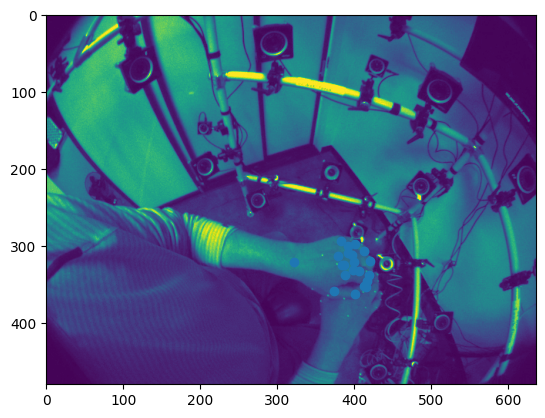

world_hand_pose_center [ -1.0184746 -38.491344   23.978489 ]
cam_pos [-127.71653748  279.93609619   -5.22389221]


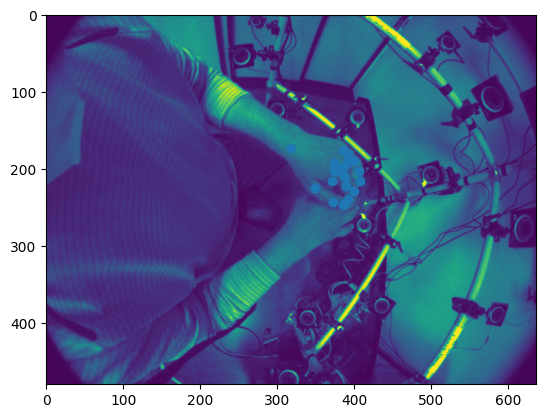

world_hand_pose_center [ -1.0184746 -38.491344   23.978489 ]
cam_pos [-154.84033203  250.40809631   81.28453827]


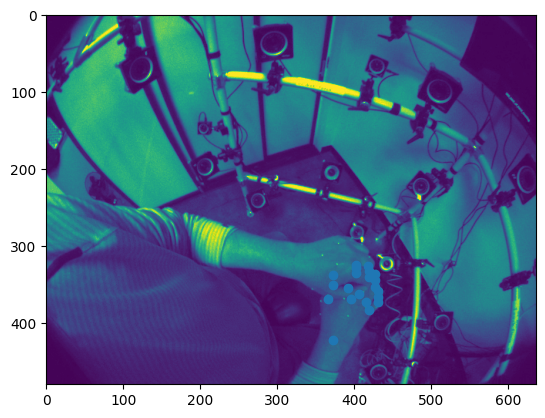

world_hand_pose_center [  10.853195 -119.546234   89.6429  ]
cam_pos [-127.71653748  279.93609619   -5.22389221]


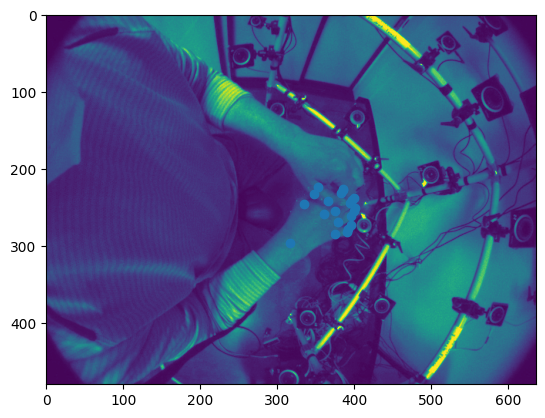

world_hand_pose_center [  10.853195 -119.546234   89.6429  ]
cam_pos [-154.84033203  250.40809631   81.28453827]


{0: {1: PinholePlaneCameraModel(96x96, f=(174.82026274245194, 174.82026274245194) c=(47.5, 47.5),
  2: PinholePlaneCameraModel(96x96, f=(204.35853859778953, 204.35853859778953) c=(47.5, 47.5)},
 1: {1: PinholePlaneCameraModel(96x96, f=(185.3666465475014, 185.3666465475014) c=(47.5, 47.5),
  2: PinholePlaneCameraModel(96x96, f=(232.42533875782786, 232.42533875782786) c=(47.5, 47.5)}}

In [23]:
tracker = HandTracker(model, HandTrackerOpts())

crop_cameras = tracker.gen_crop_cameras_analysis(
    #cameras         = [view.camera for view in input_frame.views],
    input_frame     = input_frame,
    camera_angles   = image_pose_stream._hand_pose_labels.camera_angles,
    hand_model      = hand_model,
    gt_tracking     = gt_tracking,
    min_num_crops   = 1,
)
crop_cameras

In [24]:
res = tracker.track_frame(input_frame, hand_model, crop_cameras)

## Put ELP Stereo Camera

In [34]:
IMG_WIDTH = 640
IMG_HEIGHT = 480

# k1, k2, k3, k4, p1, p2, k5, k6
distortion_coeffs_left = (
    -3.7539305827469560e-02, 
    -8.7553205432575471e-03,
    2.2015408171895236e-03, 
    -6.6218076061138698e-04,
    0, 0, 0, 0
)
camera_to_world_xf_left = np.zeros((4, 4))
camera_to_world_xf_left[:3, :3] = [
    [9.9997658245714527e-01,  5.5910744958795095e-04,  6.8206990981942916e-03,],
    [-5.4903304536865717e-04, 9.9999875583076248e-01, -1.4788169738349651e-03,],
    [-6.8215174296769373e-03, 1.4750375543776898e-03,  9.9997564528550886e-01 ],
]
#camera_to_world_xf_left[:3, 3] = [
cam_left = camera.Fisheye62CameraModel(
    width   = IMG_WIDTH,
    height  = IMG_HEIGHT,
    f       = (2.3877057700850656e+02, 2.3903223316525276e+02),
    c       = (3.1846939219741773e+02, 2.4685137381795201e+02),
    distort_coeffs = distortion_coeffs_left,
    camera_to_world_xf = np.eye(4)
)


distortion_coeffs_right = (
    -3.6790400486095221e-02, 
    -8.2041573433038941e-03,
    1.0552974220937024e-03, 
    -2.5841665172692902e-04,
    0, 0, 0, 0
)
camera_to_world_xf_right = np.zeros((4, 4))
camera_to_world_xf_right[:3, :3] = [
    [9.9999470555416226e-01, 1.1490100298631428e-03, 3.0444440536135159e-03,],
    [-1.1535052313709361e-03, 9.9999824663038117e-01, 1.4751819698614872e-03,],
    [-3.0427437166985561e-03, -1.4786859417328980e-03, 9.9999427758290704e-01 ],
]
#camera_to_world_xf_right[:3, 3] = [
cam_right = camera.Fisheye62CameraModel(
    width   = IMG_WIDTH,
    height  = IMG_HEIGHT,
    f       = (2.3952183485043457e+02, 2.3981379751051574e+02),
    c       = (3.1286224145189811e+02, 2.5158397962108106e+02),
    distort_coeffs = distortion_coeffs_right,
    camera_to_world_xf = camera_to_world_xf_right
)

####  mediapipe

In [18]:
FRAME_IDX = 88

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    max_num_hands = 2,
    
    model_complexity = 1,
    min_detection_confidence = 0.3, 
    min_tracking_confidence = 0.3
)

res = hands.process(
    cv2.cvtColor(
        input_frame.views[2].image,
        cv2.COLOR_GRAY2RGB
    )
)

print(res.multi_handedness)



[classification {
  index: 1
  score: 0.962252498
  label: "Right"
}
]


I0000 00:00:1724500342.522157   32324 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1724500342.558758   33159 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.06), renderer: NVIDIA GeForce RTX 3060/PCIe/SSE2
W0000 00:00:1724500342.570543   33147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1724500342.594853   33144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/hjp/.conda/envs/umetrack/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
